In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

C:\Users\acer\anaconda31\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
Using TensorFlow backend.
C:\Users\acer\anaconda31\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\acer\anaconda31\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\acer\anaconda31\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprec

In [2]:
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 10
predict_values_exp = 72
lag_exp=4

In [3]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [7]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save("model.h5")
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [9]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [10]:
import pandas as pd
series = pd.read_excel(r'C:\Users\acer\Desktop\Wind.xlsx',index_col="DateTime")
series.head()

,Air temperature | ('C),Pressure | (atm),Wind speed | (m/s),Wind direction | (deg),Power generated by system | (kW)
DateTime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256,27370.3


In [11]:
del series['Air temperature | (\'C)']
del series['Pressure | (atm)']
del series['Wind speed | (m/s)']
del series['Wind direction | (deg)']
series.head()

,Power generated by system | (kW)
DateTime,
2007-01-01 00:00:00,33688.1
2007-01-01 01:00:00,37261.9
2007-01-01 02:00:00,30502.9
2007-01-01 03:00:00,28419.2
2007-01-01 04:00:00,27370.3


In [12]:
for i in range(0,10):
  series = series[:-1]
series.tail()

,Power generated by system | (kW)
DateTime,
2012-12-31 09:00:00,6110.57
2012-12-31 10:00:00,6251.34
2012-12-31 11:00:00,6899.17
2012-12-31 12:00:00,4514.49
2012-12-31 13:00:00,1561.25


In [13]:
raw_values = series.values
diff_values = difference(raw_values, 1)

In [14]:
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [15]:
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]


In [16]:
scaler, train_scaled, test_scaled = scale(train, test)


In [17]:
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)



Epoch 1/1
52477/52477 [==============================] - 112s 2ms/step - loss: 0.0142
Epoch 1/1
52477/52477 [==============================] - 106s 2ms/step - loss: 0.0138
Epoch 1/1
52477/52477 [==============================] - 102s 2ms/step - loss: 0.0136
Epoch 1/1
52477/52477 [==============================] - 99s 2ms/step - loss: 0.0134
Epoch 1/1
52477/52477 [==============================] - 104s 2ms/step - loss: 0.0134
Epoch 1/1
52477/52477 [==============================] - 111s 2ms/step - loss: 0.0133
Epoch 1/1
52477/52477 [==============================] - 133s 3ms/step - loss: 0.0133


In [18]:
predictions = list()
expectations = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Hour=1, Predicted=684.632777, Expected=0.000000
Hour=2, Predicted=271.117677, Expected=725.355000
Hour=3, Predicted=1088.029380, Expected=314.976000
Hour=4, Predicted=723.521090, Expected=0.000000
Hour=5, Predicted=699.419965, Expected=0.000000
Hour=6, Predicted=1136.021599, Expected=0.000000
Hour=7, Predicted=1534.178500, Expected=0.000000
Hour=8, Predicted=1849.590960, Expected=0.000000
Hour=9, Predicted=2109.973876, Expected=0.000000
Hour=10, Predicted=2331.371180, Expected=0.000000
Hour=11, Predicted=2505.256153, Expected=0.000000
Hour=12, Predicted=2617.477739, Expected=0.000000
Hour=13, Predicted=2661.263713, Expected=1279.770000
Hour=14, Predicted=3917.569521, Expected=2610.950000
Hour=15, Predicted=5164.180579, Expected=2893.040000
Hour=16, Predicted=5310.513363, Expected=680.289000
Hour=17, Predicted=2924.470726, Expected=1316.470000
Hour=18, Predicted=3366.456810, Expected=2730.490000
Hour=19, Predicted=4583.105806, Expected=8771.750000
Hour=20, Predicted=10440.341067, Expect

In [19]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))*100))

Mean Absolute Percent Error:  62.5516927383462


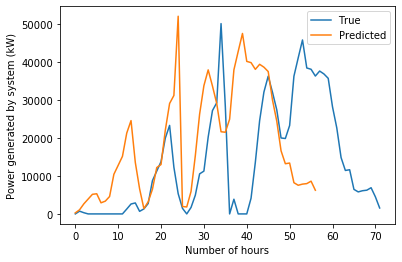

In [20]:
pyplot.plot(raw_values[-predict_values_exp:], label="True")
pyplot.plot(predictions, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()

In [21]:
import numpy as np
X_test=np.array([[10.926,0.979103,9.014,229]])
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [22]:
from keras.models import load_model
model=load_model('model.h5')

In [24]:
yhat = model.predict(X_test)
yhat[0][0]*1000

131.6978633403778